In [362]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from stingray import Lightcurve
import binaryCorr
import copy
import glob,os
import numpy as np
import scipy
import astropy.io.fits as fits
import matplotlib as mpl
import matplotlib.pyplot as plt
colors = {
    'red': '#E24A33',
    'blue': '#348ABD',
    'green': '#8EBA42',
    'orange': '#FBC15E',
    'purple': '#988ED5',
    'pink': '#FFB5B8',
    'gray': '#777777'
}
plt.style.use('science')
plt.rcParams['text.usetex'] = True
from astropy.table import Table
from astropy.modeling import models
import stingray
from stingray.gti import create_gti_from_condition, gti_border_bins, time_intervals_from_gtis, cross_two_gtis, create_gti_mask
from stingray.utils import show_progress
from stingray.fourier import avg_cs_from_events, avg_pds_from_events, poisson_level, get_average_ctrate
from stingray import AveragedPowerspectrum, AveragedCrossspectrum, EventList, Lightcurve
from stingray.modeling.parameterestimation import PSDLogLikelihood
from scipy.optimize import curve_fit
#from sklearn.mixture import GaussianMixturet
from sklearn import mixture
from sklearn.cluster import KMeans
# sphinx_gallery_thumbnail_number = 2
import emd, vmdpy
from scipy import signal, ndimage
from scipy import interpolate
import numpy as np
# import binaryCorr
import sys
import stingray.pulse as STpulse
from scipy.optimize import curve_fit
from stingray.pulse.search import epoch_folding_search, z_n_search, phase_dispersion_search
# plt.style.use('science')
# plt.rcParams['text.usetex'] = True
#from sklearn.mixture import GaussianMixturet
import scipy.stats
from stingray.pulse import fftfit
from numpy import *
from scipy.interpolate import CubicSpline
from scipy.signal import hilbert

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [363]:
def hxbary(input,output,orbitfile):
        header = pyfits.open(input)[1].header
        # if header['OBS_MODE'] != 'Pointing':
        #     print('The Pointing mode is required!')
        #     #os.sys.exit()
        ra = header['RA_OBJ']
        dec = header['DEC_OBJ']
        print(ra,dec)
        os.system("hxbary  evtfile=%s  orbitfile=%s  ra=%lf  dec=%lf eph=2 clobber=yes"%(evt, orbitfile,  ra, dec))
        #print("barycorr ra=%s dec=%s refframe=ICRS infile=%s outfile=%s orbitfiles=%s"%(ra,dec,input,output,orbitfile))
        #Ephemeris (1 for DE200,2 for DE405)"

In [364]:
def write_gti_fits(gti,p1,p2):
    col1 = fits.Column(name='start', format='D', array=gti[:, 0])
    col2 = fits.Column(name='stop', format='D', array=gti[:, 1])
    cols = fits.ColDefs([col1, col2])
    hdu = fits.BinTableHDU.from_columns(cols)
    hdu.header['EXTNAME'] = 'GTI'
    hdu.writeto('gti_tmp_%s_%s_%s.fit'%(obsid,p1,p2), overwrite=True)

In [365]:
def Do_vmd(lc, alpha, tau, K, DC, init, tol):
    u, u_hat, omega = vmdpy.VMD(lc, alpha, tau, K, DC, init, tol)
    imfs = u
    imf_out = imfs.T
    return imfs

In [366]:
def plot_imfs_vmd(t, imfs, lc,long):
    N_c = len(imfs)
    left, width = 0.1, 0.85
    bottom = 0.1
    spacing = 0.0
    height = 1./(N_c + 1) - 0.03
    
    fig = plt.figure('imfs',figsize=[10, (N_c + 1)*8./5.])
    for i in range(N_c + 1):
        j = N_c - i
        rect_plot = [left, bottom + j*height, width, height]
        if i == 0:
            ax_plot = fig.add_axes(rect_plot)
            ax_plot.plot(t[:long], lc[:long], color='k')
            ax_plot.set_ylabel(r'Signal', fontsize=20)
            ax_plot.tick_params(axis="x", labelsize=0, which='major', length=6, width=1)
            ax_plot.tick_params(axis="y", labelsize=0, which='major',length=0, width=0)
            ax_plot.tick_params(axis="x", labelsize=0, which='minor', length=4, width=1)
            ax_plot.tick_params(axis="y", labelsize=0, which='minor',length=0, width=0)
        elif (i > 0) and (i < N_c):
            ax_plot = fig.add_axes(rect_plot, sharex = ax_plot)
            ax_plot.plot(t[:long], imfs[i-1, :long], color='k')
            ax_plot.set_xlabel(r'Time', fontsize=20)
            ax_plot.set_ylabel(r'C$_{%s}$'%(i), fontsize=20)
            ax_plot.tick_params(axis="x", labelsize=0, which='major', length=6, width=1)
            ax_plot.tick_params(axis="y", labelsize=0, which='major',length=0, width=0)
            ax_plot.tick_params(axis="x", labelsize=0, which='minor', length=4, width=1)
            ax_plot.tick_params(axis="y", labelsize=0, which='minor',length=0, width=0)
        elif i == N_c:
            ax_plot = fig.add_axes(rect_plot, sharex = ax_plot)
            ax_plot.plot(t[:long], imfs[i-1, :long], color='k')
            ax_plot.set_xlabel(r'Time', fontsize=20)
            ax_plot.set_ylabel(r'C$_{%s}$'%(i), fontsize=20)
            ax_plot.tick_params(axis="x", labelsize=15, which='major', length=6, width=1)
            ax_plot.tick_params(axis="y", labelsize=0, which='major',length=0, width=0)
            ax_plot.tick_params(axis="x", labelsize=15, which='minor', length=4, width=1)
            ax_plot.tick_params(axis="y", labelsize=0, which='minor',length=0, width=0)

In [367]:
def plot_pds(lc_total, lc_decomp, bin_size):
    ps_total = stingray.AveragedPowerspectrum(lc_total, segment_size = bin_size, norm='abs')
    ps_decomp = stingray.AveragedPowerspectrum(lc_decomp, segment_size = bin_size, norm='abs')
    ps_total = ps_total.rebin_log(f=0.01)
    ps_decomp = ps_decomp.rebin_log(f=0.01)
    # fig = plt.figure('PDS')
    # plt.errorbar(ps_total.freq, ps_total.power, xerr = ps_total.freq[0]/2., 
    #              yerr = ps_total.power_err, color = 'k', fmt = '-', ms = 0, drawstyle='steps-mid')
    # plt.step(ps_decomp.freq, ps_decomp.power, color='C1', label='Decomposed QPO')
    # plt.xlabel('Frequency (Hz)')
    # plt.ylabel('Power (Arbitrary Units)')
    # plt.ylim(np.min(ps_total.power),np.max(ps_total.power))
    # #plt.ylim(2e3,5e7)
    # plt.xscale('log')
    # plt.yscale('log')
    # plt.legend()
    # plt.show()
    return ps_total, ps_decomp

In [368]:
def read_lc(lc_file, intervel):
    lc_data = fits.open(lc_file)
    lc = lc_data[1].data['RATE']
    time = lc_data[1].data['TIME']
    start = lc_data[1].header['TSTART']
    timedel=lc_data[1].header['timedel']
    error = lc_data[1].data['ERROR']
    GTI0 = lc_data[2].data['START']
    GTI1 = lc_data[2].data['STOP']
#    time1 = time[(time >= GTI0[intervel - 1]) & (time <= GTI1[intervel - 1])]
#    lc1 = lc[(time >= GTI0[intervel - 1]) & (time <= GTI1[intervel - 1])] 
#    dt = time[1] - time[0]
#    stop = len(time) * dt
#    t = np.arange(0.0, stop, dt)
    GTI = np.vstack([GTI0, GTI1])
    GTI = GTI.T
    lc_data.close()
    #time=time+start
    return time, lc, error, GTI, timedel

In [369]:
def efold(time, cts, period, nbins = 16, dt = 1, cts_err = None):
    phase = STpulse.pulse_phase(time, 1./period)    
    phase_ind = phase // (1./nbins)
    mk = [phase_ind == j for j in range(nbins)]    
    #---
    bin_time = np.array([len(cts[mk[k]]) * dt for k in range(nbins)])
    #---    
    if cts_err is None:    
        bin_cts = np.array([cts[mk[k]].sum() for k in range(nbins)])
        bin_cts_err = np.sqrt(bin_cts)

        bin_cts = bin_cts/bin_time
        bin_cts_err = bin_cts_err/bin_time
    else:
        bin_cts = np.array([cts[mk[k]].sum() for k in range(nbins)])
        bin_cts_err = np.array([np.sqrt((cts_err[mk[k]]**2).sum()) for k in range(nbins)])

        bin_cts = bin_cts/bin_time
        bin_cts_err = bin_cts_err/bin_time  
    
    #---
    bin_phase = np.linspace(0, 1, nbins + 1)
    bin_phase = (bin_phase[1:] + bin_phase[:-1])/2.    
    return bin_phase, bin_cts, bin_cts_err#unit: cts/s

In [370]:
def efold_qpo(phase, cts, nbins = 16, dt = 1, cts_err = None):
    #phase = STpulse.pulse_phase(time, 1./period)    
    phase_ind = phase // (1./nbins)
    mk = [phase_ind == j for j in range(nbins)]    
    #---
    bin_time = np.array([len(cts[mk[k]]) * dt for k in range(nbins)])
    #---    
    if cts_err is None:    
        bin_cts = np.array([cts[mk[k]].sum() for k in range(nbins)])
        bin_cts_err = np.sqrt(bin_cts)

        bin_cts = bin_cts/bin_time
        bin_cts_err = bin_cts_err/bin_time
    else:
        bin_cts = np.array([cts[mk[k]].sum() for k in range(nbins)])
        bin_cts_err = np.array([np.sqrt((cts_err[mk[k]]**2).sum()) for k in range(nbins)])

        bin_cts = bin_cts/bin_time
        bin_cts_err = bin_cts_err/bin_time  
    
    #---
    bin_phase = np.linspace(0, 1, nbins + 1)
    bin_phase = (bin_phase[1:] + bin_phase[:-1])/2.    
    return bin_phase, bin_cts, bin_cts_err#unit: cts/s

In [371]:
def efold_search(time, cts, prange, ref=0, cts_err = None, nbins = 16, dt = 1):
    def const(x, a):
        return a    
    time = time - ref
    chi2 = np.zeros(len(prange))
    for i, p in enumerate(prange):
#         print(i)
        bin_phase, bin_cts, bin_cts_err = efold(time, cts, p, nbins = nbins, dt = dt, cts_err = cts_err)
        #---
        popt, pcov = curve_fit(const, bin_phase, bin_cts, sigma = bin_cts_err, p0 = [bin_cts.mean()])
        model = popt[0]
        chi2[i] = (((model - bin_cts) / bin_cts_err)**2).sum()        
    #---------------------------
    return prange, chi2

In [372]:
import portion as P
def combine_gti_continuous(wgti):#, GTI):#将连续的gti合并一起
    print("len(wgti)=",len(wgti))
    if not len(wgti)==0:
        print("wgti[0][0],wgti[0][1]",wgti[0][0],wgti[0][1])
        x=P.closed(wgti[0][0],wgti[0][1])
    else:
        x=[]
    for i in range(len(wgti)):
        x=x|P.closed(wgti[i][0],wgti[i][1])

    print("len(x)=",len(x))
    l=[]
    for i in range(len(x)):
        x1=[]
        x1.append(x[i].lower)
        x1.append(x[i].upper)
        l.append(x1)
    return l

In [373]:
obsid=20201208
path='/Volumes/WD_BLACK/Data/1A0535p262/HXMT/date_combine/%s'%obsid
#lc_file='/Volumes/WD_BLACK/Data/HHT_test/123456789/ni123456789mpu7_sr.lc'
#lc_files=glob.glob('%s/P*/HE/*40.0_50.0_net.lc'%path)
lc_files=glob.glob('%s/P*/HE/*25_80_net.lc'%path)
print(len(lc_files))
#for 20201208
lc_files=lc_files[1:]+["%s"%lc_files[0]]
print(lc_files)
lcs=[]
EXPOs=[]
for i in lc_files:
    time0, rate0, error0, GTI, dt = read_lc(i, 2)
    mk = rate0 > 0
    lc = Lightcurve(time0[mk], rate0[mk], dt = dt, gti=GTI, input_counts=False)
    #lc = Lightcurve(time0, rate0, dt = dt, gti=GTI, input_counts=False)
    EXPO=fits.open(i)[1].header['exposure']
    EXPOs.append(EXPO)
    lcs.append(lc)
j=0
while j < len(lcs):
    print(lcs[j].tstart)
    if j == 0:
        lc_new=lcs[0]
    if j > 0:
        lc_new=lc_new.join(lcs[j])
    j+=1

exposure=sum(EXPOs)
time0, rate0, error0=lc_new.time,lc_new.countrate,lc_new.countrate_err
#要看是否有数据和分解成分长度有差异（一般去除一个点），或者数据开头有只有几个点的情况（去除前面的点是情况而定）
time0=time0[1:]
rate0=rate0[1:]
error0=error0[1:]

t=time0
time0=time0-time0[0]

8
['/Volumes/WD_BLACK/Data/1A0535p262/HXMT/date_combine/20201208/P031431601010-20201208-03-01/HE/1A0535p262_HE_25_80_net.lc', '/Volumes/WD_BLACK/Data/1A0535p262/HXMT/date_combine/20201208/P031431601011-20201208-03-01/HE/1A0535p262_HE_25_80_net.lc', '/Volumes/WD_BLACK/Data/1A0535p262/HXMT/date_combine/20201208/P031431601012-20201208-03-01/HE/1A0535p262_HE_25_80_net.lc', '/Volumes/WD_BLACK/Data/1A0535p262/HXMT/date_combine/20201208/P031431601013-20201208-03-01/HE/1A0535p262_HE_25_80_net.lc', '/Volumes/WD_BLACK/Data/1A0535p262/HXMT/date_combine/20201208/P031431601014-20201208-03-01/HE/1A0535p262_HE_25_80_net.lc', '/Volumes/WD_BLACK/Data/1A0535p262/HXMT/date_combine/20201208/P031431601015-20201208-03-01/HE/1A0535p262_HE_25_80_net.lc', '/Volumes/WD_BLACK/Data/1A0535p262/HXMT/date_combine/20201208/P031431601016-20201208-03-01/HE/1A0535p262_HE_25_80_net.lc', '/Volumes/WD_BLACK/Data/1A0535p262/HXMT/date_combine/20201208/P030409901401-20201208-01-01/HE/1A0535p262_HE_25_80_net.lc']
282016544.0
2

In [374]:
dt,np.mean(rate0),exposure

(1.0, 1825.5784, 21917.5)

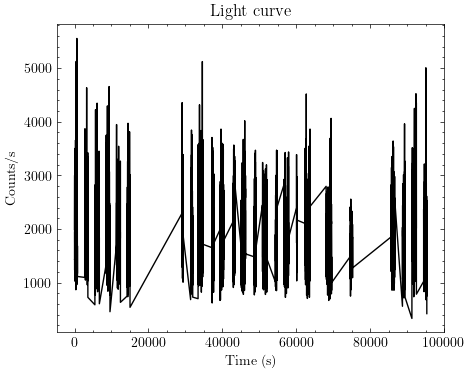

In [375]:
plt.figure(figsize=(5, 4))
plt.plot(time0, rate0,'-k')
plt.title("Light curve")
plt.xlabel(f"Time (s)")
plt.ylabel(f"Counts/s")
plt.legend()

0.018906777142657368
(159,)
21926 21926
103.22894051427295


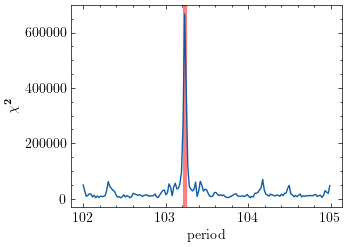

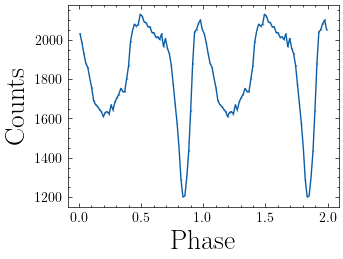

0.27908860549589826


In [376]:
###DO THIS ONLY FOR PULSARS###
###HOW to subtract pulse from lcurve?###

#step 1: searching for the spin period:
#how to choose the resolution?
dp = 104**2/(t.max()-t.min())/2./3.
#dp = 1e-5
print(dp)
prange = np.arange(102, 105, dp) #explain why
print(prange.shape)


# efolding method, an example for binned data
print(len(t),len(rate0))
prange, chi2 = efold_search(t, rate0, prange, ref=0, cts_err = error0, nbins = 16, dt = 1)
period = prange[np.argmax(chi2)]
print(period)
plt.errorbar(prange, chi2)
plt.xlabel('period')
plt.ylabel('$\mathbf{\chi^2}$')
plt.axvline(period, lw=3, alpha=0.5, color='r', label='Correct frequency')
plt.show()

#step 2: fold the light curve to pulse profile
phase_bins, profile, profile_err=efold(t, rate0, period, nbins = 64, dt = 1, cts_err = error0)
plt.errorbar(np.hstack([phase_bins, phase_bins +1]), np.hstack([profile, profile]),\
             yerr = np.hstack([profile_err, profile_err]),fmt = '-')
plt.xlabel('Phase', fontsize = 20)
plt.ylabel('Counts', fontsize = 20)
plt.show()
rms=(profile.max()-profile.min())/(profile.max()+profile.min())
print(rms)

In [377]:
#step 3: Use interpolated to build a continuous function of the pulse profile 

# 假设你有一些观测值
x_observed = phase_bins
y_observed = profile

# 使用观测值创建三次样条插值对象
cubic_spline = CubicSpline(x_observed, y_observed)

#step 4: get the count rate at any phase

phase = STpulse.pulse_phase(t, 1./period)
# 获取任意 x 位置点的 y 值
x_position = phase
y_interpolated = cubic_spline(x_position)

#step 4: subtract pulse from light curve:
rate_unpulse=rate0-y_interpolated
lc_unpulse = Lightcurve(time0, rate_unpulse, dt = dt, input_counts=False)

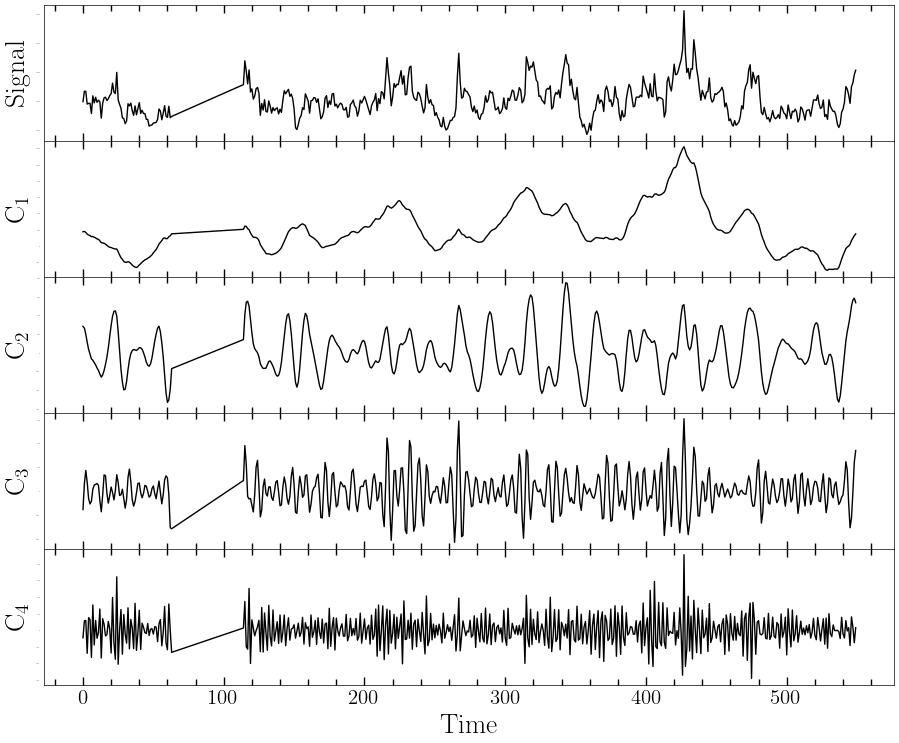

In [378]:
#-----------------------------------------
#alpha = int(alpha_opt)       # moderate bandwidth constraint  
alpha=100
tau = 0.           # noise-tolerance (no strict fidelity enforcement)   
K = 4
DC = 1            # no DC part imposed  
init = 1           # initialize omegas uniformly   ## We originally set as 0
tol = 1e-7
#-----------------------------------------
#imfs = Do_vmd(rate0, alpha, tau, K, DC, init, tol)

#Use un-pulsed light curve to do VMD:
imfs = Do_vmd(rate_unpulse, alpha, tau, K, DC, init, tol)
plot_imfs_vmd(time0, imfs, rate0,500)

21926 21926


31it [00:00, 18548.28it/s]
42it [00:00, 22964.51it/s]
31it [00:00, 21280.43it/s]
42it [00:00, 18365.38it/s]
42it [00:00, 19125.04it/s]
42it [00:00, 22765.67it/s]
42it [00:00, 26650.65it/s]
42it [00:00, 20229.76it/s]


Text(0.5, 1.0, 'Date: 2020-11-20')

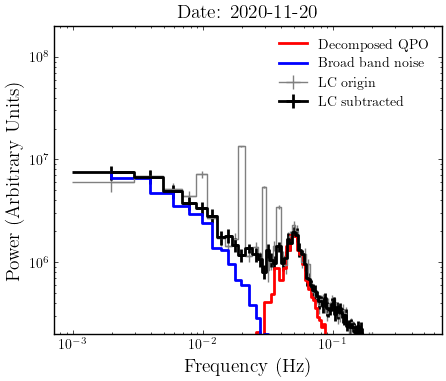

In [379]:
num = K
N=K-1
print(len(time0),len(imfs[num - N]))
lc_decomp = Lightcurve(time0, imfs[num - N], dt = dt)
lc_decomp1 = Lightcurve(time0, imfs[num - N-1], dt = dt)
#plot_pds(lc_new, lc_decomp,256)
ps_total0, ps_decomp_0=plot_pds(lc_new, lc_decomp,512)
ps_total0, ps_decomp1_0=plot_pds(lc_new, lc_decomp1,512)
ps_total, ps_decomp=plot_pds(lc_unpulse, lc_decomp,512)
ps_total, ps_decomp1=plot_pds(lc_unpulse, lc_decomp1,512)

fig, axs = plt.subplots(1,1,figsize=(5, 4))
axs.errorbar(ps_total0.freq, ps_total0.power, xerr = ps_total.freq[0]/2., 
             yerr = ps_total.power_err, color = 'gray', fmt = '-',lw=1, ms = 0, drawstyle='steps-mid',label='LC origin')
axs.errorbar(ps_total.freq, ps_total.power, xerr = ps_total.freq[0]/2., 
             yerr = ps_total.power_err, color = 'k', fmt = '-',lw=2, ms = 0, drawstyle='steps-mid', label='LC subtracted')
axs.step(ps_decomp.freq, ps_decomp.power,color='red',lw=2, label='Decomposed QPO')
axs.step(ps_decomp.freq, ps_decomp1.power, color='blue',lw=2, label='Broad band noise')
#axs.set_xlabel('Frequency (Hz)')
axs.set_ylim(np.min(ps_total.power),np.max(ps_total.power))
axs.set_ylim(2e5,2e8)
axs.set_xscale('log')
axs.set_yscale('log')
plt.legend()
axs.set_xlabel('Frequency (Hz)',fontsize=14, fontweight='bold',fontname='Times New Roman')
axs.set_ylabel('Power (Arbitrary Units)',fontsize=14, fontweight='bold',fontname='Times New Roman')
for spine in ['top', 'right', 'bottom', 'left']:  
    axs.spines[spine].set_linewidth(1)
axs.tick_params(axis='x', which='both',color='black',direction='in')
axs.set_title('Date: 2020-11-20', fontsize=14, fontweight='bold',fontname='Times New Roman') 
#axs.tick_params(axis='both', which='major', length=3, width=1, color='black') 
#plt.savefig("/Users/kldsky/Desktop/1A0535_results/QPO_decomposed_20201120.pdf")

In [380]:
sample_rate=len(time0)/(exposure)
IP, IF, IA = emd.spectra.frequency_transform(imfs.T,sample_rate, 'nht')

Text(0, 0.5, 'Frequency (Hz)')

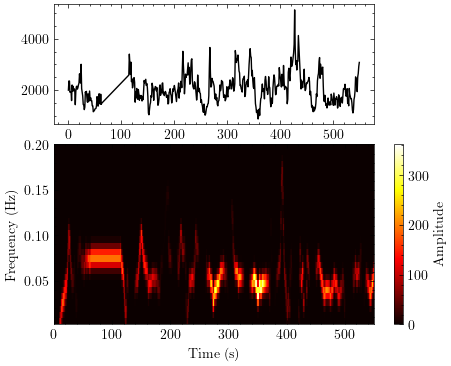

In [381]:
##### Carrier frequency histogram definition
long=500
freq_edges, freq_centres = emd.spectra.define_hist_bins(1/512, 0.5, 24*3, 'linear')
f, hht = emd.spectra.hilberthuang(IF[:,num-N], IA[:, num-N], freq_edges, mode='amplitude', sum_time=False)
hht = ndimage.gaussian_filter(hht, 1)
time_centres = np.arange(long+1)-.5
plt.figure(figsize=(5, 4))
# Add signal and IA
plt.axes([.1, .6, .64, .3])
#plt.plot(time0[:long],imfs.T[:long, num-N], 'k')
plt.plot(time0[:long],rate0[:long], 'k')
#plt.plot(time0[:long],imfs.T[:long, num-N-1], 'g')
#plt.plot(IA[:, num-N], 'r')
#plt.legend(['IMF', 'IF'])
#plt.xlim(0, long)
#plt.ylim(-50,50)

# Add IF axis and legend
plt.axes([.1, .1, .8, .45])

# Plot HHT
# print(hht[:, :long].shape)
# print(time0[:long].shape)
plt.pcolormesh(time0[:long+1], freq_edges, hht[:, :long], cmap='hot', vmin=0)

# Set colourbar
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

# Set lims and labels
#plt.xlim(0, long)
plt.ylim(1/512, 0.2)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

# rect = patches.Rectangle((50, 8), 100, 12, edgecolor='k', facecolor='none')
# plt.gca().add_patch(rect)

In [382]:
f=np.mean(IF[:,num-N])
print(f)
print(1/f)

0.057650825329296496
17.34580544663649


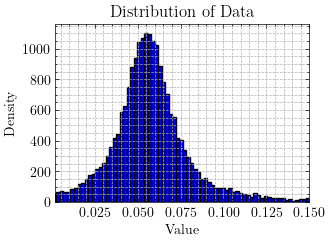

In [383]:
# plt.figure(figsize=(6, 4))
plt.hist(IF[:,num-N], bins=256, color='blue', edgecolor='black')

# 添加标题和轴标签
plt.title('Distribution of Data')
plt.xlabel('Value')
plt.ylabel('Density')

# 显示网格
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0.002,0.15)
# 显示图形
plt.tight_layout()
plt.show()

In [384]:
Reimf = hilbert(imfs[num - N])
phase = np.angle(Reimf)
normalized_phase = (phase + np.pi) / (2 * np.pi)
normalized_phase = np.mod(normalized_phase, 1.0)
print(len(normalized_phase),len(rate0))

21926 21926


In [385]:
template =scipy.stats.binned_statistic(normalized_phase,rate0,bins=16,statistic='mean')
#template_unpulse =scipy.stats.binned_statistic(normalized_phase,rate_unpulse+np.mean(rate0),bins=16,statistic='mean')
#template=template_unpulse

fractional RMS of flux is:  0.186046921063689
fractional RMS of flux is:  0.13220657372250263


Text(0.5, 0, 'Phase')

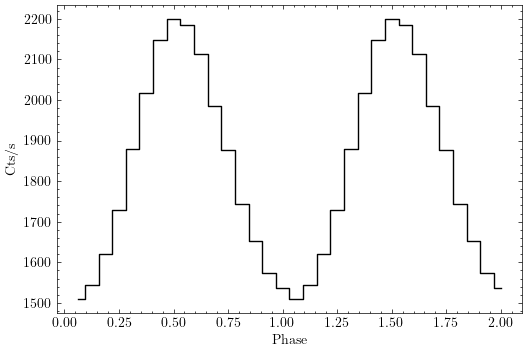

In [386]:
profile = template[0]
phase_bins = template[1][1:]
rms=(profile.max()-profile.min())/(profile.max()+profile.min())
print("fractional RMS of flux is: ", rms)
std_deviation = np.std(profile)
# 计算平均值
mean_value = np.mean(profile)
# 计算标准差除以平均值
std_deviation_over_mean = std_deviation / mean_value
print("fractional RMS of flux is: ", std_deviation_over_mean)
profile=np.hstack([profile, profile])
phase_bins = np.hstack([phase_bins, phase_bins + 1])
plt.figure(figsize=(6, 4))
plt.errorbar(phase_bins, profile, drawstyle='steps-mid',color='k',ecolor='k')
plt.ylabel('Cts/s')
plt.xlabel('Phase')

In [387]:
phase_bins, profile

(array([0.06251243, 0.12500959, 0.18750676, 0.25000392, 0.31250109,
        0.37499825, 0.43749541, 0.49999258, 0.56248974, 0.62498691,
        0.68748407, 0.74998123, 0.8124784 , 0.87497556, 0.93747273,
        0.99996989, 1.06251243, 1.12500959, 1.18750676, 1.25000392,
        1.31250109, 1.37499825, 1.43749541, 1.49999258, 1.56248974,
        1.62498691, 1.68748407, 1.74998123, 1.8124784 , 1.87497556,
        1.93747273, 1.99996989]),
 array([1509.55677322, 1543.74891157, 1620.848894  , 1728.81038334,
        1879.84665973, 2018.40941477, 2148.7798583 , 2199.64173535,
        2184.92819246, 2114.00757202, 1985.8564226 , 1876.41720574,
        1743.18668127, 1651.7264646 , 1573.783908  , 1536.65196737,
        1509.55677322, 1543.74891157, 1620.848894  , 1728.81038334,
        1879.84665973, 2018.40941477, 2148.7798583 , 2199.64173535,
        2184.92819246, 2114.00757202, 1985.8564226 , 1876.41720574,
        1743.18668127, 1651.7264646 , 1573.783908  , 1536.65196737]))

In [388]:
#####make GTI files from QPO phases#####
phase_edge=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in phase_edge:
    target_phase_start = round(i, 1)
    target_phase_end = round(i+0.1, 1)
    print(target_phase_start,target_phase_end)
    time_points=(normalized_phase >= target_phase_start) & (normalized_phase <= target_phase_end)
    GTI_low = np.around(t[time_points] - dt/2., 5)
    GTI_high = np.around(t[time_points] + dt/2., 5)
    GTI_pre = np.vstack((list(GTI_low), list(GTI_high)))
    GTI_pre = GTI_pre.T
    GTI = combine_gti_continuous(GTI_pre)
    GTI=np.array(GTI)
    GTI[0][0],GTI[0][1]
    np.savetxt('gti_tmp_%s_%s_%s.txt'%(obsid,target_phase_start,target_phase_end), GTI)
    write_gti_fits(GTI,target_phase_start,target_phase_end)

0.0 0.1
len(wgti)= 2221
wgti[0][0],wgti[0][1] 282016558.0 282016559.0
len(x)= 1238
0.1 0.2
len(wgti)= 2168
wgti[0][0],wgti[0][1] 282016560.0 282016561.0
len(x)= 1245
0.2 0.3
len(wgti)= 2125
wgti[0][0],wgti[0][1] 282016562.0 282016563.0
len(x)= 1251
0.3 0.4
len(wgti)= 2096
wgti[0][0],wgti[0][1] 282016545.0 282016546.0
len(x)= 1240
0.4 0.5
len(wgti)= 2110
wgti[0][0],wgti[0][1] 282016566.0 282016567.0
len(x)= 1240
0.5 0.6
len(wgti)= 2112
wgti[0][0],wgti[0][1] 282016546.0 282016547.0
len(x)= 1228
0.6 0.7
len(wgti)= 2188
wgti[0][0],wgti[0][1] 282016548.0 282016549.0
len(x)= 1231
0.7 0.8
len(wgti)= 2244
wgti[0][0],wgti[0][1] 282016549.0 282016550.0
len(x)= 1228
0.8 0.9
len(wgti)= 2360
wgti[0][0],wgti[0][1] 282016551.0 282016552.0
len(x)= 1239
0.9 1.0
len(wgti)= 2302
wgti[0][0],wgti[0][1] 282016555.0 282016556.0
len(x)= 1228


In [389]:
print("Obsid:", obsid)
print("Average Freq:", np.mean(IF[:,num-N]), "Hz")
print("Average Rate:", np.mean(rate0), "cts/s")
print("Total exposure:", exposure)

Obsid: 20201208
Average Freq: 0.057650825329296496 Hz
Average Rate: 1825.5784 cts/s
Total exposure: 21917.5


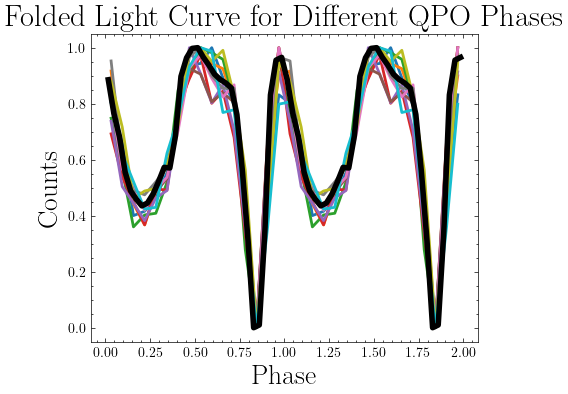

In [391]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

# 假设已有 normalized_phase, t, rate0, error0, STpulse.pulse_phase, efold 等必要数据和函数
target_phases = [(i/10, (i+1)/10) for i in range(10)]  # 生成十个相位区间
nbins = 16

# 预设颜色循环器
colors = cycle(plt.cm.tab10(np.linspace(0, 1, 10)))  # 使用Tab10调色板生成不同颜色

# 创建画布
plt.figure(figsize=(5, 4))

for i, (target_phase_start, target_phase_end) in enumerate(target_phases):
    #print(target_phase_start, target_phase_end)
    time_points = (normalized_phase >= target_phase_start) & (normalized_phase <= target_phase_end)
    t_QPO = t[time_points]
    rate_QPO = rate0[time_points]
    error_QPO = error0[time_points]
    
    # 计算自旋相位
    spinphase_QPO = STpulse.pulse_phase(t_QPO, 1. / period)
    
    # 折叠光变曲线
    phase_bins_QPOphase, profile_QPOphase, profile_QPOphase_err = efold(t_QPO, rate_QPO, period, nbins=nbins, dt=1, cts_err=error_QPO)
    profile_QPOphase=(profile_QPOphase-np.min(profile_QPOphase))/(np.max(profile_QPOphase)-np.min(profile_QPOphase))
    # 在同一张图上绘制，使用不同颜色
    plt.errorbar(np.hstack([phase_bins_QPOphase, phase_bins_QPOphase + 1]), 
                 np.hstack([profile_QPOphase, profile_QPOphase]), 
                 fmt='-', lw=2, label=f'Phase {target_phase_start:.1f}-{target_phase_end:.1f}', color=next(colors))
    
target_phase_start = 0.0
target_phase_end = 1.0
#print(target_phase_start,target_phase_end)
time_points=(normalized_phase >= target_phase_start) & (normalized_phase <= target_phase_end)
t_QPO=t[time_points]
rate_QPO=rate0[time_points]
error_QPO=error0[time_points]
spinphase_QPO = STpulse.pulse_phase(t_QPO, 1./period) 
phase_bins_QPOphase, profile_QPOphase, profile_QPOphase_err=efold(t_QPO, rate_QPO, period, nbins = 32, dt = 1, cts_err = error_QPO)
profile_QPOphase=(profile_QPOphase-np.min(profile_QPOphase))/(np.max(profile_QPOphase)-np.min(profile_QPOphase))
plt.errorbar(np.hstack([phase_bins_QPOphase, phase_bins_QPOphase +1]), np.hstack([profile_QPOphase, profile_QPOphase]),fmt = '-',lw=4,color='black')

# 设置图表标题和标签
plt.xlabel('Phase', fontsize=20)
plt.ylabel('Counts', fontsize=20)
#plt.legend(fontsize=12)
plt.title('Folded Light Curve for Different QPO Phases', fontsize=22)
plt.show()